# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [5]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [6]:
batchSize = 50

transform = transforms.Compose([
    transforms.ToTensor(), # this is required
    transforms.Normalize(0.8, 0.8, 0.8), # Normalizing data is optimized for training
    transforms.RandomHorizontalFlip(p=0.25),
])

workersCount = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=workersCount)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=workersCount)

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
def showImages(img_loader, count):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:count]
    images = batch[0][0:count]
    imageGrid = torchvision.utils.make_grid(images)
    imageGridNumPy = imageGrid.numpy()
    plt.imshow(imageGridNumPy.T)
    plt.imshow(np.transpose(imageGridNumPy, (1, 2, 0))) # rorate and change column to row
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.24999999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.24999999].


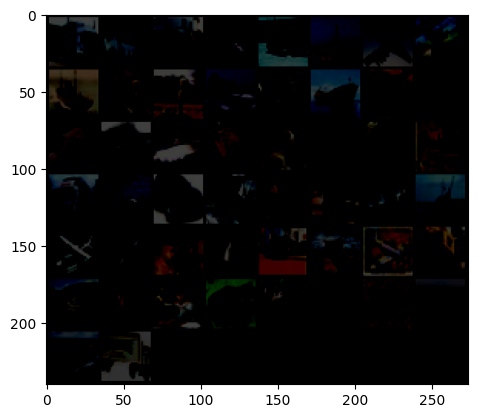

In [8]:
# Explore data
## YOUR CODE HERE ##
showImages(trainloader, batchSize)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [11]:
## YOUR CODE HERE ##
class CifarNetwork(nn.Module):
    def __init__(self):
        super().__init__() # Must call base class constructor first
        # Custom assignments
        self.step1 = nn.Sequential(
            nn.Conv2d(3, 3, 2),
            nn.Unfold(2, 1),
            nn.Fold(30, 1),
            #nn.MaxPool2d(1, stride=1, return_indices=True)
        )
        self.step2 = nn.MaxUnpool2d(100, stride=-2)
        self.step3 = nn.Sequential(
            nn.LPPool2d(2, 3, stride=2),
            nn.InstanceNorm2d(12, affine=True)
        )
        self.step4 = nn.Sequential(
            nn.Linear(23232, 10), # Final output need to have length of 10
            #nn.Linear(1000, 100),
            #nn.Linear(100, 10)
        )

    def forward(self, x):
        x = F.max_pool2d(self.step1(x), 2, stride=1, return_indices=True)
        outputs, indices = x
        x = self.step2(outputs, indices)
        x = torch.flatten(x, 1)
        x = self.step4(x)
        #print('Debug tensor value')
        #print(x)
        return x
network = CifarNetwork()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.0025, momentum=0.75)

def optimize_loss(outputs, labels):
    optimizer.zero_grad() # Need to reset before every calculation
    loss = criterion(outputs, labels) ## Calculate loss
    # Optimize loss
    loss.backward()
    optimizer.step()
    return loss.item()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [17]:
## YOUR CODE HERE ##
device_src = "cpu"
if torch.cuda.is_available():
    device_src = "cuda"
device = torch.device(device_src)
network.to(device)
print(f'Training using {device_src}')

loss_stat = []
for epoch in range(20):
    loss = 0.0 # 0.0 so it is float
    for i, data in enumerate(trainloader, 0):
        # inputs, labels = data
        inputs, labels = [row.to(device) for row in data]
        outputs = network(inputs) # Fit the model
        loss += optimize_loss(outputs, labels) # Sum it, so we have the AVG value
    print(f'Epoch {epoch + 1}, loss = {loss / len(trainloader):.3f}')
    loss_stat.append(loss)
    loss = 0.0
print(f'Done with final loss = {loss_stat[-1]}')

Training using cpu
Epoch 1, loss = 1.406
Epoch 2, loss = 1.408
Epoch 3, loss = 1.407
Epoch 4, loss = 1.403
Epoch 5, loss = 1.397
Epoch 6, loss = 1.400
Epoch 7, loss = 1.394
Epoch 8, loss = 1.399
Epoch 9, loss = 1.402
Epoch 10, loss = 1.394
Epoch 11, loss = 1.394
Epoch 12, loss = 1.397
Epoch 13, loss = 1.394
Epoch 14, loss = 1.391
Epoch 15, loss = 1.391
Epoch 16, loss = 1.386
Epoch 17, loss = 1.390
Epoch 18, loss = 1.386
Epoch 19, loss = 1.388
Epoch 20, loss = 1.386
Done with final loss = 1386.382272183895


Plot the training loss (and validation loss/accuracy, if recorded).

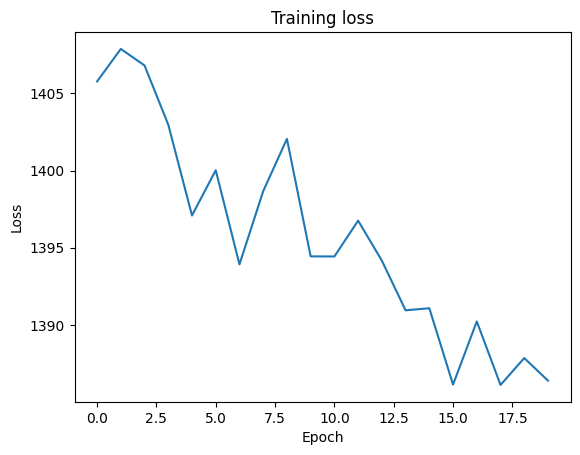

In [18]:
## YOUR CODE HERE ##
plt.plot(loss_stat)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [19]:
dataiter = iter(testloader)
images, labels = next(dataiter)
actualData = [labels[j] for j in range(batchSize)]
outputs = network(images)


#print(images.shape)
#print(labels.shape)
#print(labels)
#print(outputs.shape)


values, predicted = torch.max(outputs, 1)
#print(values)
#print(predicted)

predictResult = [predicted[j] for j in range(batchSize)]
compare = [[x, y, 1 if x == y else 0] for x, y in zip(predictResult, actualData)]
correct = sum(x[2] == 1 for x in compare)
accuracy = round(correct / batchSize * 100, 2)
print(f"Correct: {correct}/{batchSize} ({accuracy}%)")

Correct: 24/50 (48.0%)


## Saving your model
Using `torch.save`, save your model for future loading.

In [20]:
## YOUR CODE HERE ##
PATH = './cifa10_network.pth'
torch.save(network.state_dict(), PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**

I would run this kind of model on a machine having a GPU.
Also I would build an optimize program, something like in the 1st project, we can test the model with different parameters and find the best model.

